# Telecom Churn

In [27]:
%pip install scikit-learn pandas matplotlib seaborn numpy scipy imbalanced-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
# Setup
import os
import glob
import pandas as pd
import numpy as np
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support
from scipy.stats import ks_2samp
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

RANDOM_STATE = 42
DATA_DIR = os.path.join(os.getcwd(), 'data')

pd.set_option('display.max_columns', None)
print('DATA_DIR:', DATA_DIR)

DATA_DIR: /home/pcgr/Code/churn-predict/data


In [29]:
# Load dataset(s) from /data
def load_first_csv(data_dir: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files found in {data_dir}')
    print('Using CSV:', csvs[0])
    df = pd.read_csv(csvs[0])
    return df

df_raw = load_first_csv(DATA_DIR)
print('Shape:', df_raw.shape)
df_raw.head()

Using CSV: /home/pcgr/Code/churn-predict/data/customer_churn_telecom_services.csv
Shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
# Definir coluna alvo
target_col = "Churn"

# Normalizar o alvo para binário 0/1
df = df_raw.copy()
def to_binary(series):
    if series.dtype == 'O':
        return series.str.lower().map({'yes':1,'sim':1,'true':1,'y':1,'1':1,'no':0,'nao':0,'false':0,'n':0,'0':0}).fillna(series)
    return series
df[target_col] = to_binary(df[target_col])
if df[target_col].dtype == 'O':
    # Se ainda for objeto, tente astype(int) após mapear os únicos
    uniques = df[target_col].unique()
    print('Warning: target still object. Uniques:', uniques)

# Organiza TotalCharges como float
if df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip().replace('', np.nan), errors='coerce')
    print('TotalCharges converted to float. Missing:', df['TotalCharges'].isna().sum())

print('Class balance:', df[target_col].value_counts(dropna=False))
print('Missing per column:\n', df.isna().sum())

Class balance: Churn
0    5174
1    1869
Name: count, dtype: int64
Missing per column:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


# Pré processamento
SeniorCitizen está na categoria numérica, mas parece que o modelo trata numéricos binários bem. De qualquer forma pode ser bom pensar melhor no que fazer aí.

In [31]:
# Remove linhas com NaN em TotalCharges
before = len(df)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
after = len(df)
print(f'Dropped {before - after} rows with NaN TotalCharges. New shape: {df.shape}')
print('Class balance after drop:', df[target_col].value_counts(dropna=False))

Dropped 11 rows with NaN TotalCharges. New shape: (7032, 20)
Class balance after drop: Churn
0    5163
1    1869
Name: count, dtype: int64


In [32]:
# Pré processamento: separar X e y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == 'O']
numeric_cols = [c for c in X.columns if c not in categorical_cols]
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

numeric_pipeline = Pipeline(steps=[
    ('impute', 'passthrough'),
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ], remainder='drop'
)

print('Preprocessor ready.')

Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Preprocessor ready.


In [33]:
# Split dos dados em treino, validação e teste (50/25/25 por padrão)
from typing import Tuple

def split_train_val_test(
    X, y,
    train_frac: float = 0.5,
    val_frac: float = 0.25,
    test_frac: float = 0.25,
    random_state: int = RANDOM_STATE
):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-8, "Fractions must sum to 1."
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_frac, random_state=random_state, stratify=y
    )
    val_ratio_in_temp = val_frac / (train_frac + val_frac)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio_in_temp, random_state=random_state, stratify=y_temp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.5, 0.25, 0.25
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, RANDOM_STATE)

print('Shapes -> Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('Train class balance:', y_train.value_counts(normalize=True))
print('Val class balance:', y_val.value_counts(normalize=True))
print('Test class balance:', y_test.value_counts(normalize=True))

# Oversample em Train e Val (não em Test)
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)
X_val_bal, y_val_bal = ros.fit_resample(X_val, y_val)

print('Train after oversample:', y_train_bal.value_counts(normalize=True))
print('Val after oversample:', y_val_bal.value_counts(normalize=True))

Shapes -> Train: (3516, 19) Val: (1758, 19) Test: (1758, 19)
Train class balance: Churn
0    0.734073
1    0.265927
Name: proportion, dtype: float64
Val class balance: Churn
0    0.734357
1    0.265643
Name: proportion, dtype: float64
Test class balance: Churn
0    0.734357
1    0.265643
Name: proportion, dtype: float64
Train after oversample: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64
Val after oversample: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


# Baseline MLP

In [34]:
# MLP Baseline (1 hidden layer, 10 neuronios)
mlp_baseline = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(10,),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size='auto',
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,       # Usa validação interna para early stopping
        n_iter_no_change=10,
        verbose=False
    ))
])

mlp_baseline.fit(X_train_bal, y_train_bal)

# Validação 
val_proba = mlp_baseline.predict_proba(X_val_bal)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
val_auroc = roc_auc_score(y_val_bal, val_proba)
val_ks = ks_2samp(val_proba[y_val_bal == 1], val_proba[y_val_bal == 0]).statistic
val_cm = confusion_matrix(y_val_bal, val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val_bal, val_pred, average='binary')
print(f'[Validation Set]\n AUROC: {val_auroc:.4f} KS: {val_ks:.4f}')
print('Confusion Matrix (Val):\n', val_cm)
print(f'Precision: {val_precision:.4f}  Recall: {val_recall:.4f}  F1: {val_f1:.4f}')
print("\n")

# Teste Final (nunca oversampled)
test_proba = mlp_baseline.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)
test_auroc = roc_auc_score(y_test, test_proba)
test_ks = ks_2samp(test_proba[y_test == 1], test_proba[y_test == 0]).statistic
test_cm = confusion_matrix(y_test, test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary')
print(f'[Test Set]\n AUROC: {test_auroc:.4f} KS: {test_ks:.4f}')
print('Confusion Matrix (Test):\n', test_cm)
print(f'Precision: {test_precision:.4f}  Recall: {test_recall:.4f}  F1: {test_f1:.4f}')

[Validation Set]
 AUROC: 0.8394 KS: 0.5275
Confusion Matrix (Val):
 [[959 332]
 [296 995]]
Precision: 0.7498  Recall: 0.7707  F1: 0.7601


[Test Set]
 AUROC: 0.8343 KS: 0.5266
Confusion Matrix (Test):
 [[955 336]
 [106 361]]
Precision: 0.5179  Recall: 0.7730  F1: 0.6203


## Plot de Resultados do MLP Baseline

METRICS REPORT: Baseline MLP - Test Set
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1291
           1       0.52      0.77      0.62       467

    accuracy                           0.75      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.80      0.75      0.76      1758



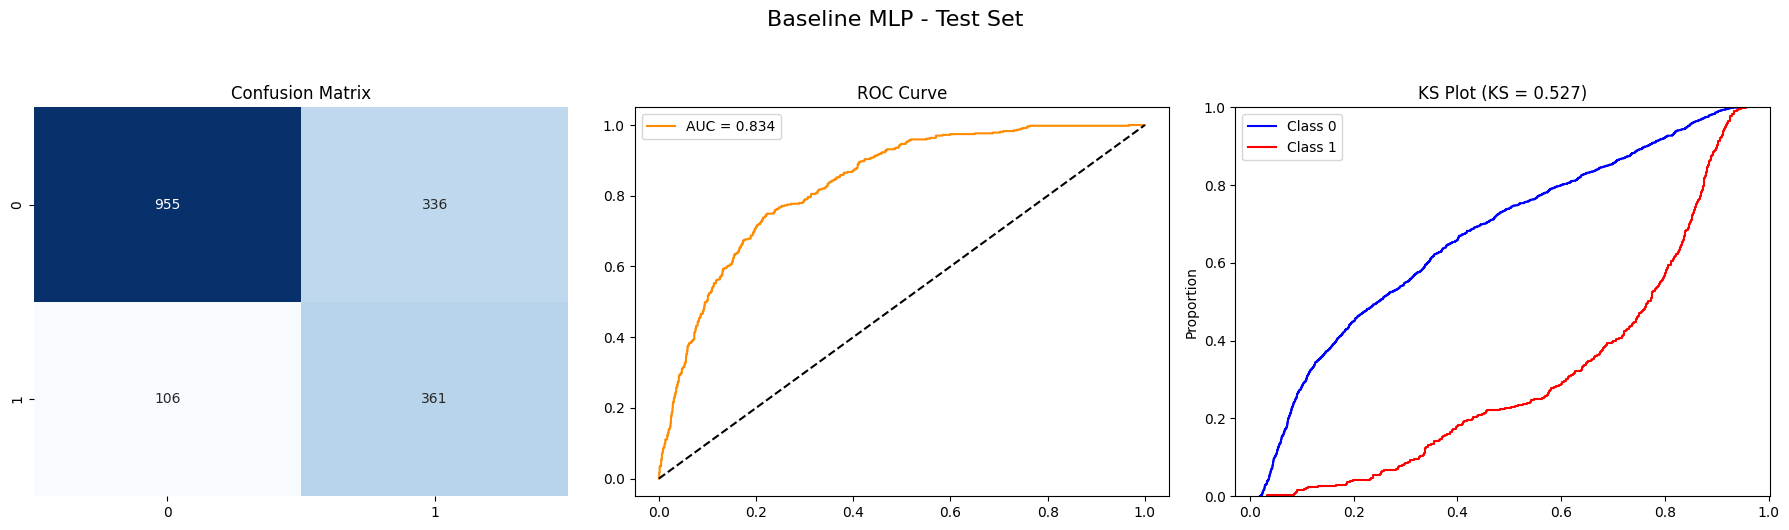

In [39]:
import scikit_plotting # Helper script for plotting model performance
# Plot Baseline MLP performance
plot_model_performance(mlp_baseline, X_test, y_test, title="Baseline MLP - Test Set")

# XGBoost 


In [35]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# XGBoost Baseline
xgb_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,        # Increased: learn more trees
        learning_rate=0.05,      # Decreased: slower learning for better generalization
        max_depth=4,             # Decreased: less complex trees to reduce overfitting
        subsample=0.8,           # Use 80% of rows per tree
        colsample_bytree=0.8,    # Use 80% of columns per tree
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    ))
])

xgb_pipeline.fit(X_train_bal, y_train_bal)

# Validation (Evaluated on ORIGINAL distribution, not oversampled)
val_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]
val_pred_xgb = (val_proba_xgb >= 0.5).astype(int)
val_auroc_xgb = roc_auc_score(y_val, val_proba_xgb)
val_ks_xgb = ks_2samp(val_proba_xgb[y_val == 1], val_proba_xgb[y_val == 0]).statistic
val_cm_xgb = confusion_matrix(y_val, val_pred_xgb)
val_precision_xgb, val_recall_xgb, val_f1_xgb, _ = precision_recall_fscore_support(y_val, val_pred_xgb, average='binary')

print(f'[XGBoost - Validation Set (Real Dist)]\n AUROC: {val_auroc_xgb:.4f} KS: {val_ks_xgb:.4f}')
print('Confusion Matrix (Val):\n', val_cm_xgb)
print(f'Precision: {val_precision_xgb:.4f}  Recall: {val_recall_xgb:.4f}  F1: {val_f1_xgb:.4f}')
print("\n")

# Final Test
test_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
test_pred_xgb = (test_proba_xgb >= 0.5).astype(int)
test_auroc_xgb = roc_auc_score(y_test, test_proba_xgb)
test_ks_xgb = ks_2samp(test_proba_xgb[y_test == 1], test_proba_xgb[y_test == 0]).statistic
test_cm_xgb = confusion_matrix(y_test, test_pred_xgb)
test_precision_xgb, test_recall_xgb, test_f1_xgb, _ = precision_recall_fscore_support(y_test, test_pred_xgb, average='binary')

print(f'[XGBoost - Test Set]\n AUROC: {test_auroc_xgb:.4f} KS: {test_ks_xgb:.4f}')
print('Confusion Matrix (Test):\n', test_cm_xgb)
print(f'Precision: {test_precision_xgb:.4f}  Recall: {test_recall_xgb:.4f}  F1: {test_f1_xgb:.4f}')

[XGBoost - Validation Set (Real Dist)]
 AUROC: 0.8498 KS: 0.5430
Confusion Matrix (Val):
 [[972 319]
 [110 357]]
Precision: 0.5281  Recall: 0.7645  F1: 0.6247


[XGBoost - Test Set]
 AUROC: 0.8343 KS: 0.5104
Confusion Matrix (Test):
 [[954 337]
 [114 353]]
Precision: 0.5116  Recall: 0.7559  F1: 0.6102


## Plot Resultados XGBoost


METRICS REPORT: XGBoost - Test Set
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1291
           1       0.51      0.76      0.61       467

    accuracy                           0.74      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.79      0.74      0.76      1758



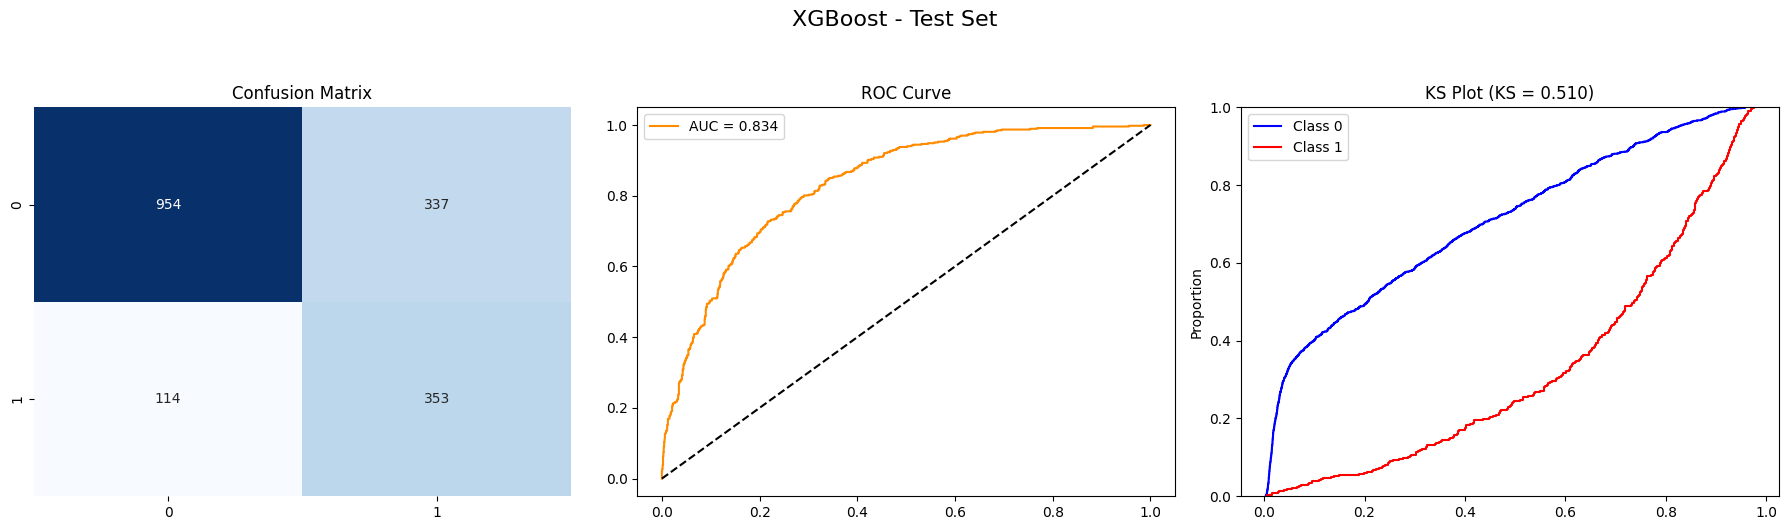

In [40]:
import scikit_plotting # Helper script for plotting model performance
# Plot XGBoost performance
plot_model_performance(xgb_pipeline, X_test, y_test, title="XGBoost - Test Set")

# Hyperparameters Tuning With Optuna

In [36]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress verbose logs

## Creating Optimized MLP

In [37]:
def objective_mlp(trial):
    # Search Space
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 128))
    
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    lr_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
    
    # Model
    clf = MLPClassifier(
        hidden_layer_sizes=tuple(layers),
        activation='relu',
        solver='adam',
        alpha=alpha,
        learning_rate_init=lr_init,
        max_iter=10000, # Slightly lower for speed during search
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=10
    )
    
    # Pipeline (Preprocessing + Model)
    pipeline = Pipeline(steps=[('prep', preprocessor), ('clf', clf)])
    
    # Train on Balanced Data
    pipeline.fit(X_train_bal, y_train_bal)
    
    # Evaluate on Validation (Real Distribution)
    preds = pipeline.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

print("Optimizing MLP...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=20)

print("Best MLP Params:", study_mlp.best_params)

Optimizing MLP...
Best MLP Params: {'n_layers': 1, 'n_units_l0': 94, 'alpha': 0.00015696256201133563, 'learning_rate_init': 0.0019878673433248962}


### Training and Plotting Optimized MLP

Training Final MLP with Best Params...
[Final MLP - Validation Set]
 AUROC: 0.8478 KS: 0.5451
Confusion Matrix (Val):
 [[913 378]
 [ 79 388]]
Precision: 0.5065  Recall: 0.8308  F1: 0.6294


[Final MLP - Test Set]
 AUROC: 0.8349 KS: 0.5153
Confusion Matrix (Test):
 [[896 395]
 [ 95 372]]
Training Final MLP with Best Params...
[Final MLP - Validation Set]
 AUROC: 0.8478 KS: 0.5451
Confusion Matrix (Val):
 [[913 378]
 [ 79 388]]
Precision: 0.5065  Recall: 0.8308  F1: 0.6294


[Final MLP - Test Set]
 AUROC: 0.8349 KS: 0.5153
Confusion Matrix (Test):
 [[896 395]
 [ 95 372]]
Precision: 0.4850 Recall: 0.7966 F1: 0.6029
METRICS REPORT: Final MLP - Test Set
              precision    recall  f1-score   support

           0       0.90      0.69      0.79      1291
           1       0.49      0.80      0.60       467

    accuracy                           0.72      1758
   macro avg       0.69      0.75      0.69      1758
weighted avg       0.79      0.72      0.74      1758



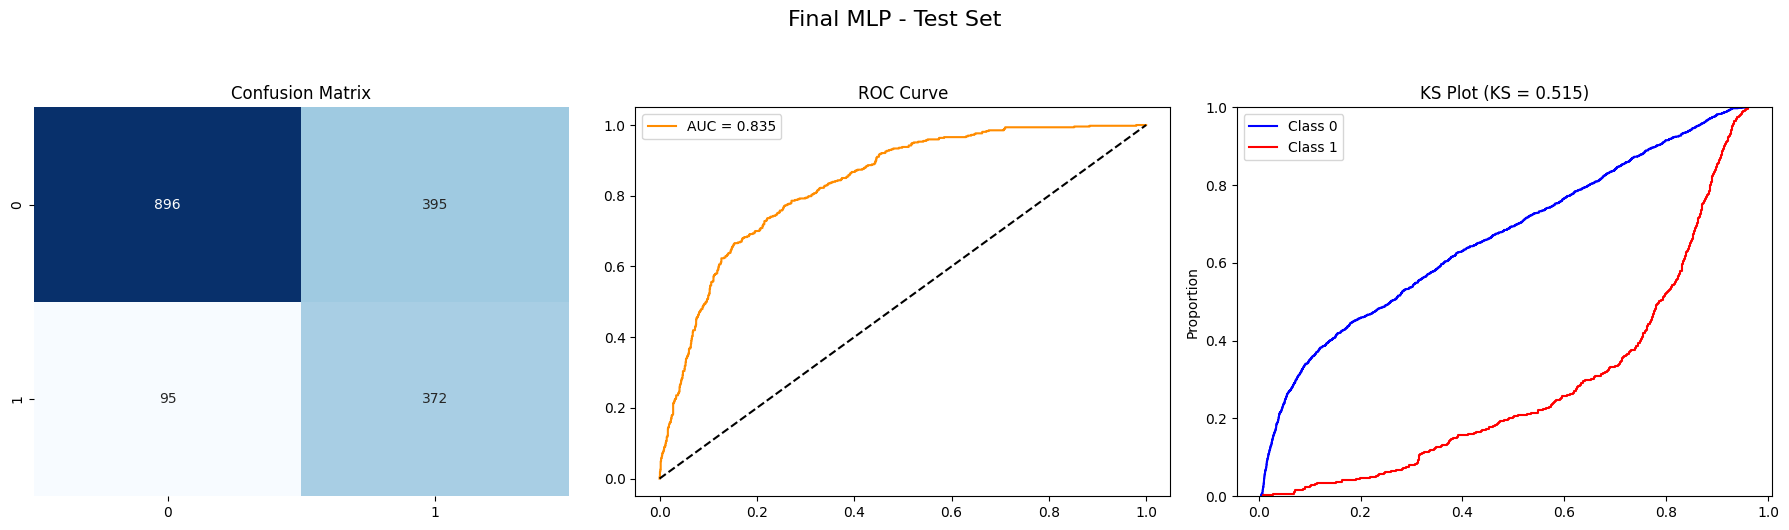

In [38]:
import scikit_plotting # Helper script for plotting model performance

# Extract best parameters
best_params_mlp = study_mlp.best_params

# Reconstruct hidden layers tuple
layers = []
for i in range(best_params_mlp['n_layers']):
    layers.append(best_params_mlp[f'n_units_l{i}'])

# Create Final Model
final_mlp = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', MLPClassifier(
        hidden_layer_sizes=tuple(layers),
        activation='relu',
        solver='adam',
        alpha=best_params_mlp['alpha'],
        learning_rate_init=best_params_mlp['learning_rate_init'],
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=10,
        verbose=False
    ))
])

print("Training Final MLP with Best Params...")
final_mlp.fit(X_train_bal, y_train_bal)

# Validation Evaluation
val_proba = final_mlp.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
val_auroc = roc_auc_score(y_val, val_proba)
val_ks = ks_2samp(val_proba[y_val == 1], val_proba[y_val == 0]).statistic
val_cm = confusion_matrix(y_val, val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_pred, average='binary')

print(f'[Final MLP - Validation Set]\n AUROC: {val_auroc:.4f} KS: {val_ks:.4f}')
print('Confusion Matrix (Val):\n', val_cm)
print(f'Precision: {val_precision:.4f}  Recall: {val_recall:.4f}  F1: {val_f1:.4f}')
print("\n")

# Test Evaluation
test_proba = final_mlp.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)
test_auroc = roc_auc_score(y_test, test_proba)
test_ks = ks_2samp(test_proba[y_test == 1], test_proba[y_test == 0]).statistic
test_cm = confusion_matrix(y_test, test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary')

print(f'[Final MLP - Test Set]\n AUROC: {test_auroc:.4f} KS: {test_ks:.4f}')
print('Confusion Matrix (Test):\n', test_cm)

# Reconstruct hidden layers tuple
layers = []
for i in range(best_params_mlp['n_layers']):
    layers.append(best_params_mlp[f'n_units_l{i}'])

# Create Final Model
final_mlp = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', MLPClassifier(
        hidden_layer_sizes=tuple(layers),
        activation='relu',
        solver='adam',
        alpha=best_params_mlp['alpha'],
        learning_rate_init=best_params_mlp['learning_rate_init'],
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=10,
        verbose=False
    ))
])

print("Training Final MLP with Best Params...")
final_mlp.fit(X_train_bal, y_train_bal)

# Validation Evaluation
val_proba = final_mlp.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
val_auroc = roc_auc_score(y_val, val_proba)
val_ks = ks_2samp(val_proba[y_val == 1], val_proba[y_val == 0]).statistic
val_cm = confusion_matrix(y_val, val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_pred, average='binary')

print(f'[Final MLP - Validation Set]\n AUROC: {val_auroc:.4f} KS: {val_ks:.4f}')
print('Confusion Matrix (Val):\n', val_cm)
print(f'Precision: {val_precision:.4f}  Recall: {val_recall:.4f}  F1: {val_f1:.4f}')
print("\n")

# Test Evaluation
test_proba = final_mlp.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)
test_auroc = roc_auc_score(y_test, test_proba)
test_ks = ks_2samp(test_proba[y_test == 1], test_proba[y_test == 0]).statistic
test_cm = confusion_matrix(y_test, test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary')

print(f'[Final MLP - Test Set]\n AUROC: {test_auroc:.4f} KS: {test_ks:.4f}')
print('Confusion Matrix (Test):\n', test_cm)
print(f'Precision: {test_precision:.4f} Recall: {test_recall:.4f} F1: {test_f1:.4f}')

# Final Test Evaluation
plot_model_performance(final_mlp, X_test, y_test, title="Final MLP - Test Set")